In [64]:
import numpy as np
from scipy.stats import nbinom, binom
import matplotlib.pyplot as plt

In [6]:
nbinom.cdf(50,10,1/2)

0.999999984574822

In [ ]:
binom.pmf(5,10,1/2)

0.0

In [19]:
my_bin = nbinom(3,0.5)

In [20]:
my_bin.pmf(10)

0.008056640625

In [18]:
sum = 0
for i in range(11):
	sum += my_bin.cdf(i)
print(sum)

2.350069046020508


In [50]:
a = binom(2,1/2)
b = 1
print(a.cdf(b))
print(a.pmf(b))

0.75
0.5000000000000002


In [70]:
c = nbinom(2,1/2)
d = 0.5
print(c.cdf(d))
print(c.pmf(d))

0.25
0.0


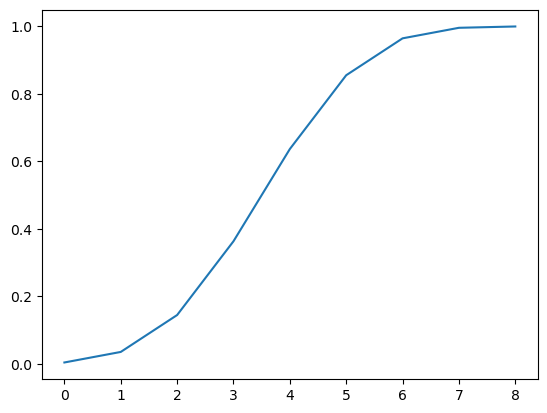

In [133]:
a = binom(8,1/2)
plt.plot(a.cdf(range(9)))

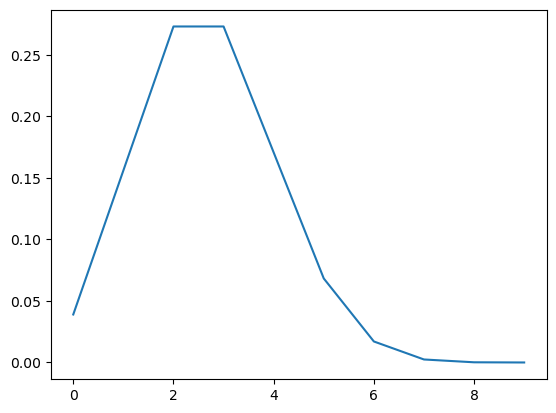

In [81]:
plt.plot(a.pmf(range(10)))

In [79]:
dice_not_mine = 8
prob = 0.99
my_binom = binom(dice_not_mine, 1/3)
final = 0
for i in range(dice_not_mine+1):
	if my_binom.cdf(i) >= prob:
		final = i
		break

print(final)

6


In [82]:
my_binom.cdf(7)

0.9998475842097241

In [122]:
c = binom(3,1/3)
d = 3
print(c.cdf(3-d))
print(1- c.cdf(d))


0.2962962962962963
0.0


In [129]:
c = binom(10,9/10)
for i in range(10):
	print(f"{i}, {c.cdf(10-i)}")

0, 1.0
1, 0.6513215599
2, 0.2639010708999999
3, 0.07019082639999996
4, 0.012795198399999989
5, 0.0016349373999999981
6, 0.00014690259999999982
7, 9.121599999999986e-06
8, 3.735999999999993e-07
9, 9.09999999999998e-09
